# Fine-tune Unet++ for Wilfire Spread Prediction
Unet++ is a fully convolution neural network for image semantic segmentation. Consist of encoder and decoder parts connected with skip connections. Encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation mask. Decoder of Unet++ is more complex than in usual Unet.

## 1. Methodology
We are going to fine-tune the pre-trained Unet++ model using the library called [Segmentation Models Pytorch](https://smp.readthedocs.io/en/latest/index.html). It is a Python library with neural networks for image segmentation based on PyTorch.

It has the following unique features:

- The library offers a high-level API that simplifies creating neural networks, requiring just two lines of code.

- It supports 11 distinct model architectures for both binary and multi-class segmentation, including the renowned U-Net model.

- Users can access 124 built-in encoders, alongside more than 500 additional encoders from the TIMM library.

- Every encoder comes with pre-trained weights, enabling faster training and improved convergence.

- A variety of commonly used metrics and loss functions are provided to streamline the training process.



## 2. Implementation

### Install External Packages

In [1]:
%%capture
!pip install segmentation-models-pytorch lightning

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Imports

In [3]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler

### Loading data
For this experiment we will use our own wildfire spread dataset. It is a set of:
 - train data + segmentation masks
 - validation data + segmentation masks
 - test data + segmentation masks

In [4]:
DATA_DIR = "/content/drive/MyDrive/Datasets/synthetic_fire_dataset/"

x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "train_annotations")

x_valid_dir = os.path.join(DATA_DIR, "valid")
y_valid_dir = os.path.join(DATA_DIR, "valid_annotations")

x_test_dir = os.path.join(DATA_DIR, "test")
y_test_dir = os.path.join(DATA_DIR, "test_annotations")

### Dataset
Writing helper class for data extraction, tranformation and preprocessing
https://pytorch.org/docs/stable/data

In [5]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class FireSegmentationDataset(Dataset):
    """
    Custom Dataset for Fire Segmentation.

    Args:
        features_dir (str): Path to the folder containing input feature files.
        masks_dir (str): Path to the folder containing annotation mask files.
    """
    def __init__(self, features_dir, masks_dir):
        self.features_dir = features_dir
        self.masks_dir = masks_dir
        self.feature_files = os.listdir(features_dir)  # List of feature files (e.g., sample_0.npy)
        self.mask_files = os.listdir(masks_dir)  # List of mask files (e.g., sample_0.npy)

    def __len__(self):
        return len(self.feature_files)  # The number of feature files (same as mask files)

    def __getitem__(self, idx):
        # Get the filenames for the specific sample
        feature_file = self.feature_files[idx]
        mask_file = self.mask_files[idx]

        # Load the feature and mask data for the specific sample
        feature_path = os.path.join(self.features_dir, feature_file)
        mask_path = os.path.join(self.masks_dir, mask_file)

        # Load the feature and mask data
        features = np.load(feature_path)
        mask = np.load(mask_path)

        # Ensure the mask is binary
        mask = (mask > 0).astype("float32")

        # Convert features and masks to PyTorch's channel-first format
        features = features.transpose(2, 0, 1)  # (height, weight, n_channels) -> (n_channels, height, weight)
        mask = mask.transpose(2, 0, 1)

        # Convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return features, mask


In [6]:
# Create the datasets
train_dataset = FireSegmentationDataset(
    features_dir=x_train_dir,
    masks_dir=y_train_dir,
)

valid_dataset = FireSegmentationDataset(
    features_dir=x_valid_dir,
    masks_dir=y_valid_dir,
)

test_dataset = FireSegmentationDataset(
    features_dir=x_test_dir,
    masks_dir=y_test_dir,
)

### Dataloader

In [7]:
# Create DataLoader for batching
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Hyperparameters

In [8]:
# Some training hyperparameters
EPOCHS = 35
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

### Area of Burned Mask

In [9]:
def calculate_area(projection_mask: np.ndarray, pixel_area: float) -> float:
    """
    Calculate the approximate area using the projection mask.

    Parameters:
    projection_mask (np.ndarray): A binary mask where pixels belonging to the region of interest are 1, others are 0.
    pixel_area (float): The area of one pixel in the same unit as the desired output area.

    Returns:
    float: The approximate area of the projection mask.
    """
    # Validate inputs
    if not isinstance(projection_mask, np.ndarray):
        raise TypeError("projection_mask must be a numpy ndarray.")
    if not np.issubdtype(projection_mask.dtype, np.integer):
        raise ValueError("projection_mask must contain integer values (e.g., 0 and 1).")
    if not (projection_mask >= 0).all() or not (projection_mask <= 1).all():
        raise ValueError("projection_mask must only contain 0s and 1s.")
    if pixel_area <= 0:
        raise ValueError("pixel_area must be a positive value.")

    # Calculate the area
    num_pixels = np.sum(projection_mask)
    total_area = num_pixels * pixel_area

    return total_area

### Fire Propagation Rate Calculation

#### Distance Calculation

In [10]:
def calculate_distances(ignition_image, projection_mask):
    """
    Calculate the distances from the ignition point to the edge of the projection mask in four directions.

    Parameters:
        ignition_image (numpy.ndarray): Binary image where ignition point is 1, and others are 0.
        projection_mask (numpy.ndarray): Binary mask with 1 for the projection area and 0 elsewhere.

    Returns:
        list: Distances [North, South, East, West] from the ignition point to the mask edge.
    """
    if ignition_image.shape != projection_mask.shape:
        raise ValueError("Ignition image and projection mask must have the same dimensions.")

    # Get the coordinates of the ignition point
    ignition_coords = np.argwhere(ignition_image == 1)
    if len(ignition_coords) == 0:
        raise ValueError("No ignition point found in the ignition image.")

    # Assume one ignition point for simplicity
    ignition_y, ignition_x = ignition_coords[0]

    # Get distances in each direction
    north_distance = np.argmax(projection_mask[:ignition_y, ignition_x][::-1] == 0)
    south_distance = np.argmax(projection_mask[ignition_y + 1:, ignition_x] == 0)
    east_distance = np.argmax(projection_mask[ignition_y, ignition_x + 1:] == 0)
    west_distance = np.argmax(projection_mask[ignition_y, :ignition_x][::-1] == 0)

    # If no 0 is found, extend to the edge of the mask
    north_distance = ignition_y if north_distance == 0 else north_distance
    south_distance = projection_mask.shape[0] - ignition_y - 1 if south_distance == 0 else south_distance
    east_distance = projection_mask.shape[1] - ignition_x - 1 if east_distance == 0 else east_distance
    west_distance = ignition_x if west_distance == 0 else west_distance

    return [north_distance, south_distance, east_distance, west_distance]

In [11]:
def calculate_propagation_rate(distances, pixel_size, forecast_days):
    """
    Calculate the propagation rate.

    Parameters:
        distances (list or tuple): A list or tuple of distances [d1, d2, d3, d4] from the center
                                   of the ignition points to the edge of the projection mask
                                   in four directions (North, South, East, West).
        pixel_size (float): The size of one pixel in real-world units (e.g., meters).
        forecast_days (int): The total number of forecast days.

    Returns:
        float: The propagation rate.
    """
    if len(distances) != 4:
        raise ValueError("The distances parameter must contain exactly four values.")

    if forecast_days <= 0:
        raise ValueError("The number of forecast days must be greater than zero.")

    total_distance = sum(distances)
    propagation_rate = (total_distance * pixel_size) / forecast_days

    return propagation_rate

### Model Building

In [12]:
class Model(pl.LightningModule):
    def __init__(self, arch, encoder_name, loss_function_name, in_channels, out_classes, **kwargs):
        """
        PyTorch Lightning Module for training segmentation models using `segmentation_models_pytorch`.

        Parameters:
            arch (str): Architecture of the segmentation model (e.g., "Unet", "DeepLabV3").
            encoder_name (str): Backbone encoder (e.g., "resnet34", "efficientnet-b0").
            loss_function_name (str): Name of the loss function ("lovasz_loss", "tversky_loss", etc.).
            in_channels (int): Number of input channels for the model.
            out_classes (int): Number of output classes for segmentation.
            **kwargs: Additional arguments for the `smp.create_model` method.
        """
        super().__init__()

        # Create the segmentation model
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        # Supported loss functions mapping
        loss_functions = {
            "lovasz_loss": smp.losses.LovaszLoss,
            "tversky_loss": smp.losses.TverskyLoss,
            "focal_loss": smp.losses.FocalLoss,
            "dice_loss": smp.losses.DiceLoss,
        }

        # Validate and initialize the loss function
        if loss_function_name not in loss_functions:
            raise ValueError(
                f"Unsupported loss function: '{loss_function_name}'. "
                f"Choose from {list(loss_functions.keys())}."
            )

        self.loss_fn = loss_functions[loss_function_name](smp.losses.BINARY_MODE, from_logits=True)

        # Initialize step metrics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, input_features):
        mask = self.model(input_features)
        return mask

    def shared_step(self, batch, stage):
        inp_feat = batch[0]  # Input_features is the first item in the batch (features)
        mask = batch[1]   # Mask is the second item in the batch (labels)

        assert inp_feat.ndim == 4  # Ensure input feature shape is (batch_size, channels, height, width)
        assert mask.ndim == 4  # Ensure mask shape is (batch_size, 1, height, width)

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0


        logits_mask = self.forward(inp_feat)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Compute the metrics for some threshold
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each input and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # Aggregate step metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Define metric functions and labels
        metric_functions = {
            "iou": smp.metrics.iou_score,
            "f1score": smp.metrics.f1_score,
            "recall": smp.metrics.recall,
            "precision": smp.metrics.precision,
            "accuracy": smp.metrics.accuracy,
            "sensitivity": smp.metrics.sensitivity,
            "specificity": smp.metrics.specificity,
        }

        # Compute per-image metrics
        per_image_metrics = {
            f"{stage}_per_image_{name}": func(tp, fp, fn, tn, reduction="micro-imagewise")
            for name, func in metric_functions.items()
        }

        # Compute dataset metrics
        dataset_metrics = {
            f"{stage}_dataset_{name}": func(tp, fp, fn, tn, reduction="micro")
            for name, func in metric_functions.items()
        }

        # Combine all metrics
        metrics = {**per_image_metrics, **dataset_metrics}

        # Log all metrics
        self.log_dict(metrics, prog_bar=True)


    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)  # Example with T_max=100
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }


### Different Training Combinations
- Encoder Name
- Loss Function

In [15]:
encoders = ["resnet34", "resnet50", "efficientnet-b3"] # Many more check out: https://smp.readthedocs.io/en/latest/encoders.html
loss_functions = ["lovasz_loss", "tversky_loss", "focal_loss", "dice_loss"]

model = Model(
    arch="unetplusplus",
    encoder_name=encoders[2],
    loss_function_name=loss_functions[1],
    in_channels=38,
    out_classes=1
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 123MB/s]


### Training

In [16]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, accelerator='gpu',)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | UnetPlusPlus | 13.6 M | train
1 | loss_fn | TverskyLoss  | 0      | train
-------------------------------------------------
13.6 M    Trainable params
0         Non-trainable params
13.6 M    Total params
54.550    Total estimated model params size (MB)
548       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


### Model Evaluation

In [17]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=True)
print(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_dataset_accuracy    │     0.7937890887260437     │
│    test_dataset_f1score    │    0.23840439319610596     │
│      test_dataset_iou      │     0.1353343427181244     │
│   test_dataset_precision   │     0.285282701253891      │
│    test_dataset_recall     │    0.20475806295871735     │
│  test_dataset_sensitivity  │    0.20475806295871735     │
│  test_dataset_specificity  │     0.904009997844696      │
│  test_per_image_accuracy   │     0.7937890291213989     │
│   test_per_image_f1score   │    0.20691367983818054     │
│     test_per_image_iou     │    0.13378381729125977     │
│  test_per_image_precision  │     0.3442031443119049     │
│   test_per_image_recall    │    0.22554080188274384     │
│ test_per_image_sensitivity │    0.22554080188274384     │
│ test_per_image_specificity │     0.9062864780426025     │
└────────────────────────────┴────────────────────────────┘

[{'test_per_image_iou': 0.13378381729125977, 'test_per_image_f1score': 0.20691367983818054, 'test_per_image_recall': 0.22554080188274384, 'test_per_image_precision': 0.3442031443119049, 'test_per_image_accuracy': 0.7937890291213989, 'test_per_image_sensitivity': 0.22554080188274384, 'test_per_image_specificity': 0.9062864780426025, 'test_dataset_iou': 0.1353343427181244, 'test_dataset_f1score': 0.23840439319610596, 'test_dataset_recall': 0.20475806295871735, 'test_dataset_precision': 0.285282701253891, 'test_dataset_accuracy': 0.7937890887260437, 'test_dataset_sensitivity': 0.20475806295871735, 'test_dataset_specificity': 0.904009997844696}]


### Test Data Inference

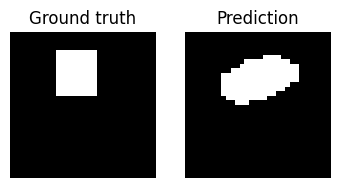

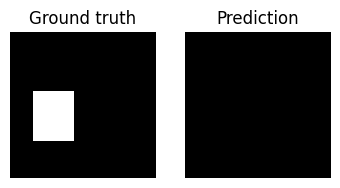

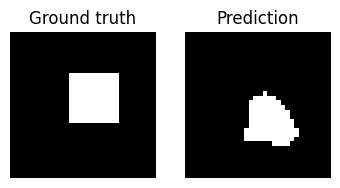

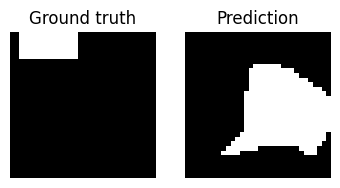

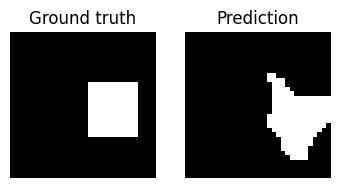

In [18]:
batch = next(iter(test_dataloader))

with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = logits.sigmoid()

for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch[0], batch[1], pr_masks)
):
    if idx <= 4:
        pr_mask = (pr_mask.numpy().squeeze() > 0.5)
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze(), cmap='gray')
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask, cmap='gray')
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

### Saving the model Locally

In [19]:
# save the model
unetplusplus = model.model
unetplusplus.save_pretrained("/content/drive/MyDrive/Colab Notebooks/uttarakhand_wildfire_spread_prediction/saved-model-dir/unetplusplus/")

# load the model
restored_model = smp.from_pretrained("/content/drive/MyDrive/Colab Notebooks/uttarakhand_wildfire_spread_prediction/saved-model-dir/unetplusplus/")
print("Model Restored Successfully")

Loading weights from local directory
Model Restored Successfully


### Inference

Loading weights from local directory
Ground Truth Burned Area: 22500000 sq. meters
Predicted Burned Area: 32250000 sq. meters
###########################################################
GROUND TRUTH PROPAGATION RATES:
###########################################################
North: 10500 m/day
South: 5000 m/day
East: 8500 m/day
West: 7000 m/day
###########################################################
PREDICTED PROPAGATION RATES:
###########################################################
North: 10500 m/day
South: 5000 m/day
East: 8500 m/day
West: 7000 m/day
###########################################################
TOTAL PROPAGATION RATE: 
###########################################################
Actual Total Propagation Rate: 31000.0 m/day
Predicted Total Propagation Rate: 31000.0 m/day


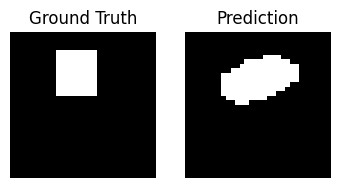

In [30]:
# load the model
restored_model = smp.from_pretrained("/content/drive/MyDrive/Colab Notebooks/uttarakhand_wildfire_spread_prediction/saved-model-dir/unetplusplus/")

# Fetch a single sample from the test dataset
image, gt_mask = test_dataset[0]

# Add a batch dimension to the single image
image = image.unsqueeze(0)  # Shape: [1, C, H, W]

# Perform inference
with torch.no_grad():
    restored_model.eval()
    logits = restored_model(image)  # Output logits

pr_mask = logits.sigmoid()  # Apply sigmoid for probabilities
pr_mask = pr_mask.squeeze(0)  # Remove batch dimension; Shape: [H, W] or [1, H, W] if channel dim remains
pr_mask = (pr_mask > 0.5).float()

ground_mask = gt_mask.numpy().squeeze().astype(np.int32)
pred_mask = pr_mask.numpy().squeeze().astype(np.int32)

# Calculating Burned Area
pixel_area = 500 * 500   # (500 m * 500 m)
actual_burned_area = calculate_area(ground_mask, pixel_area)
predicted_burned_area = calculate_area(pred_mask, pixel_area)

print("Ground Truth Burned Area:", actual_burned_area, "sq. meters")
print("Predicted Burned Area:", predicted_burned_area, "sq. meters")

print("###########################################################")

#Propagation
ignition_image = image.squeeze(0).numpy()[0, :, :]
actual_distances = calculate_distances(ignition_image, ground_mask)
predicted_distances = calculate_distances(ignition_image, pred_mask)

# Note: Suppose each pixel = 500 m
north_actual, south_actual, east_actual, west_actual = actual_distances
north_pred, south_pred, east_pred, west_pred = predicted_distances

print("GROUND TRUTH PROPAGATION RATES:")
print("###########################################################")
print("North:", north_actual * 500, "m/day")
print("South:", south_actual * 500, "m/day")
print("East:", east_actual * 500, "m/day")
print("West:", west_actual * 500, "m/day")
print("###########################################################")
print("PREDICTED PROPAGATION RATES:")
print("###########################################################")
print("North:", north_pred * 500, "m/day")
print("South:", south_pred * 500, "m/day")
print("East:", east_pred * 500, "m/day")
print("West:", west_pred * 500, "m/day")
print("###########################################################")
print("TOTAL PROPAGATION RATE: ")
actual_pr = calculate_propagation_rate(actual_distances, 500, 1)
pred_pr = calculate_propagation_rate(predicted_distances, 500, 1)
print("###########################################################")
print("Actual Total Propagation Rate:", actual_pr, "m/day")
print("Predicted Total Propagation Rate:", pred_pr, "m/day")

plt.subplot(1, 3, 2)
plt.imshow(ground_mask, cmap="gray")  # Visualize ground truth mask
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")  # Visualize predicted mask
plt.title("Prediction")
plt.axis("off")

plt.show()


### Exporting Model to ONNX

In [21]:
# to make onnx export work
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


In [22]:
import onnx
import onnxruntime

import torch

In [23]:
# load the model
loaded_model = smp.from_pretrained("/content/drive/MyDrive/Colab Notebooks/uttarakhand_wildfire_spread_prediction/saved-model-dir/unetplusplus/")
loaded_model.eval()

Loading weights from local directory


UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      38, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStatic

### Export the model to ONNX

In [24]:
onnx_model_name = "unetplusplus.onnx"

onnx_model = torch.onnx.export(
    loaded_model,
    image,  # model input
    onnx_model_name,  # where to save the model (can be a file or file-like object)
    export_params=True,  # store the trained parameter weights inside the model file
    opset_version=17,  # the ONNX version to export
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=["input"],  # the model's input names
    output_names=["output"],  # the model's output names
    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                  'output' : {0 : 'batch_size'}
                  }
)

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/model.py:17: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:
/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/jit_utils.py:308: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:663: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../tor

In [25]:
# check with onnx first
onnx_model = onnx.load(onnx_model_name)
onnx.checker.check_model(onnx_model)

### Run with onnxruntime

In [32]:
# create sample with different batch size, height and width
# from what we used in export above
# Fetch a single sample from the test dataset
img, gt_mask = test_dataset[0]

# Add a batch dimension to the single image
img = img.unsqueeze(0)  # Shape: [1, C, H, W]

ort_session = onnxruntime.InferenceSession(
    onnx_model_name, providers=["CPUExecutionProvider"]
)

# compute ONNX Runtime output prediction
ort_inputs = {"input": img.numpy()}
ort_outputs = ort_session.run(output_names=None, input_feed=ort_inputs)
print(ort_outputs[0].shape)

(1, 1, 32, 32)


Ground Truth Burned Area: 22500000 sq. meters
Predicted Burned Area: 32250000 sq. meters
###########################################################
(32, 32)
(32, 32)
GROUND TRUTH PROPAGATION RATES:
###########################################################
North: 10500 m/day
South: 5000 m/day
East: 8500 m/day
West: 7000 m/day
###########################################################
PREDICTED PROPAGATION RATES:
###########################################################
North: 10500 m/day
South: 5000 m/day
East: 8500 m/day
West: 7000 m/day
###########################################################
TOTAL PROPAGATION RATE: 
###########################################################
Actual Total Propagation Rate: 31000.0 m/day
Predicted Total Propagation Rate: 31000.0 m/day


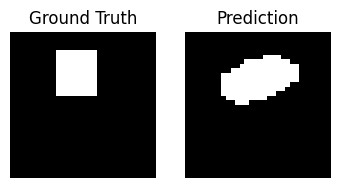

In [33]:
logits = ort_outputs[0]
# Apply sigmoid for probabilities
# Apply sigmoid function
sigmoid_out = 1 / (1 + np.exp(-logits))

pr_mask = sigmoid_out.squeeze(0)  # Remove batch dimension; Shape: [H, W] or [1, H, W] if channel dim remains
pr_mask = (pr_mask > 0.5)

ground_mask = gt_mask.numpy().squeeze().astype(np.int32)
pred_mask = pr_mask.squeeze().astype(np.int32)

# Calculating Burned Area
pixel_area = 500 * 500   # (500 m * 500 m)
actual_burned_area = calculate_area(ground_mask, pixel_area)
predicted_burned_area = calculate_area(pred_mask, pixel_area)

print("Ground Truth Burned Area:", actual_burned_area, "sq. meters")
print("Predicted Burned Area:", predicted_burned_area, "sq. meters")

print("###########################################################")

#Propagation
ignition_image = img.numpy().squeeze(0)[0, :, :]
print(ignition_image.shape)
print(ground_mask.shape)
actual_distances = calculate_distances(ignition_image, ground_mask)
predicted_distances = calculate_distances(ignition_image, pred_mask)

# Note: Suppose each pixel = 500 m
north_actual, south_actual, east_actual, west_actual = actual_distances
north_pred, south_pred, east_pred, west_pred = predicted_distances

print("GROUND TRUTH PROPAGATION RATES:")
print("###########################################################")
print("North:", north_actual * 500, "m/day")
print("South:", south_actual * 500, "m/day")
print("East:", east_actual * 500, "m/day")
print("West:", west_actual * 500, "m/day")
print("###########################################################")
print("PREDICTED PROPAGATION RATES:")
print("###########################################################")
print("North:", north_pred * 500, "m/day")
print("South:", south_pred * 500, "m/day")
print("East:", east_pred * 500, "m/day")
print("West:", west_pred * 500, "m/day")
print("###########################################################")
print("TOTAL PROPAGATION RATE: ")
actual_pr = calculate_propagation_rate(actual_distances, 500, 1)
pred_pr = calculate_propagation_rate(predicted_distances, 500, 1)
print("###########################################################")
print("Actual Total Propagation Rate:", actual_pr, "m/day")
print("Predicted Total Propagation Rate:", pred_pr, "m/day")

plt.subplot(1, 3, 2)
plt.imshow(ground_mask, cmap="gray")  # Visualize ground truth mask
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")  # Visualize predicted mask
plt.title("Prediction")
plt.axis("off")

plt.show()


### Save model to HF Hub

Login to [HF hub](https://huggingface.co/) if you want to save your model to the hub. Then, you will be able to save and load model, save metrics, and dataset name!

In [28]:
# from huggingface_hub import notebook_login

# notebook_login()

In [29]:
# loaded_model = smp.from_pretrained("/content/drive/MyDrive/Colab Notebooks/uttarakhand_wildfire_spread_prediction/saved-model-dir/u-net/")

# # if push_to_hub=True, model will be saved to repository with this name
# commit_info = loaded_model.save_pretrained(
#     save_directory="<huggingface_model_directory>",
#     push_to_hub=True,
#     metrics=test_metrics,  # optional, save metrics in model card
#     dataset="<name-of-dataset>",  # optional, save dataset name in model card
# )

In [34]:
# # Then you can load model from hub
# loaded_model = smp.from_pretrained("<huggingface_model_directory>")
# print("Loaded model:", loaded_model.__class__.__name__)